In [2]:
#import libraries
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline


import urllib

import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
#import the dataset
df = pd.read_csv("/content/dataset.csv")
df.head()

,_unit_id,category,category:confidence,image_url
0,851505458,ikat,0.3487,http://s3-eu-west-1.amazonaws.com/we-attribute...
1,851505459,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
2,851505460,polka dot,0.6709,http://s3-eu-west-1.amazonaws.com/we-attribute...
3,851505461,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
4,851505462,geometry,0.7035,http://s3-eu-west-1.amazonaws.com/we-attribute...


In [6]:
def show_image_from_url(image_url):



  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb), plt.axis('off')

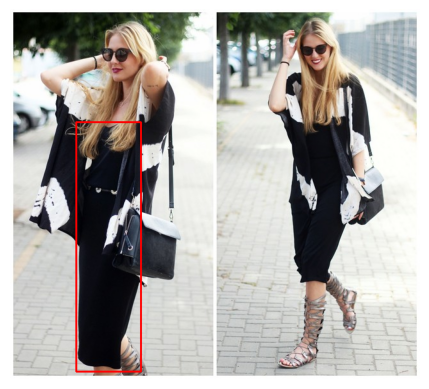

In [8]:
# importing images from URL
plt.figure()
show_image_from_url(df['image_url'].loc[9564]);

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   _unit_id             15702 non-null  int64  
 1   category             15702 non-null  object 
 2   category:confidence  15702 non-null  float64
 3   image_url            15702 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 490.8+ KB


In [10]:
# Show all categories of dress
print('All categories : \n ', df['category'].unique())

All categories : 
  ['ikat' 'plain' 'polka dot' 'geometry' 'floral' 'squares' 'scales'
 'animal' 'OTHER' 'stripes' 'tribal' 'houndstooth' 'cartoon' 'chevron'
 'stars' 'letter_numb' 'skull']


In [11]:
n_classes = df['category'].nunique()
print('Total number of unique categories:', n_classes)

Total number of unique categories: 17


In [12]:
df = df.loc[(df['category'] != 'OTHER')].reset_index(drop=True)

In [13]:
#image processing
def image_processing(image_url):

  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)


  image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)


  image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)


  mask = cv2.inRange(image_hsv, (0,255,255), (0,255,255))


  if len(np.where(mask != 0)[0]) != 0:
        y1 = min(np.where(mask != 0)[0])
        y2 = max(np.where(mask != 0)[0])
  else:
    y1 = 0
    y2 = len(mask)

  if len(np.where(mask != 0)[1]) != 0:
    x1 = min(np.where(mask != 0)[1])
    x2 = max(np.where(mask != 0)[1])
  else:
    x1 = 0
    x2 = len(mask[0])


  image_cropped = image_gray[y1:y2, x1:x2]
  image_100x100 = cv2.resize(image_cropped, (100, 100))


  image_arr = image_100x100.flatten()
  return image_arr

In [14]:
!pip install gdown

In [15]:
# import gdown for storing large volume of data and download publicly available files
import gdown

url = 'https://drive.google.com/uc?id=1B6_rtcmGRy49hqpwoJT-_Ujnt6cYj5Ba'
output = 'X.npy'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1B6_rtcmGRy49hqpwoJT-_Ujnt6cYj5Ba
From (redirected): https://drive.google.com/uc?id=1B6_rtcmGRy49hqpwoJT-_Ujnt6cYj5Ba&confirm=t&uuid=720405d9-d479-4f54-a1c2-184a21855fd4
To: /content/X.npy
100%|██████████| 1.22G/1.22G [00:08<00:00, 141MB/s]


'X.npy'

In [16]:
X = np.load('/content/X.npy')
X[0:3]
X.shape

array([[0.29803922, 0.29803922, 0.29803922, ..., 0.60392157, 0.6       ,
        0.29803922],
       [0.4627451 , 0.29803922, 0.29803922, ..., 0.29803922, 0.29803922,
        0.29803922],
       [0.30196078, 0.29803922, 0.29803922, ..., 0.29803922, 0.29803922,
        0.29803922]])

(15189, 10000)

<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b7869336710>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b78688870d0>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b78688e9bd0>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b78686eb050>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b78687100d0>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

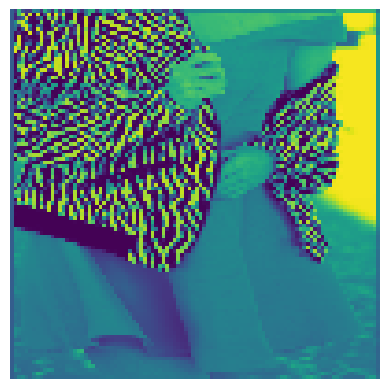

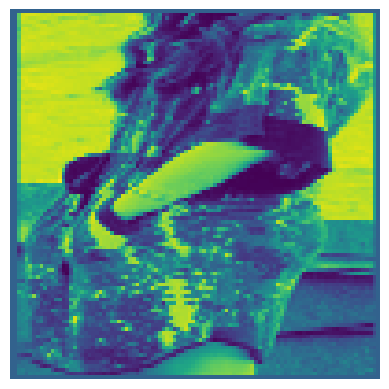

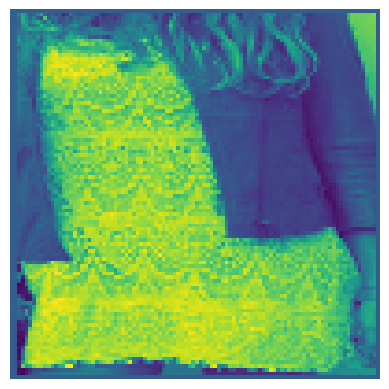

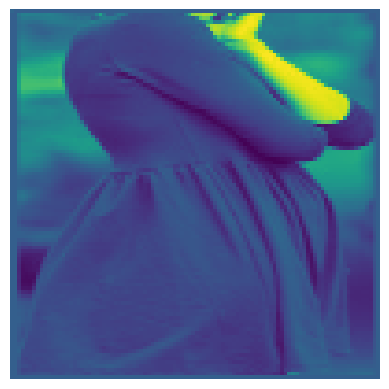

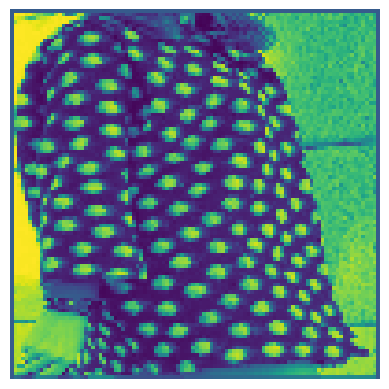

In [17]:
# reshape
np.random.seed(17)
for i in np.random.randint(0, len(X), 5):
  plt.figure()
  plt.imshow(X[i].reshape(100, 100)), plt.axis('off')

In [18]:
# convert categorical variable to numerical variable
encoder = LabelEncoder()
Targets = encoder.fit_transform(df['category'])
Targets
Targets.shape

array([ 6,  8,  9, ..., 12, 15,  9])

(15189,)

In [19]:
Y = to_categorical(Targets, num_classes = n_classes)
Y[0:3]
Y.shape

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.]])

(15189, 17)

In [20]:
# splitting training and testing data
X_test = X[14000:,]
Y_test = Y[14000:,]



X_train, X_val, Y_train, Y_val = train_test_split(X[:14000,], Y[:14000,], test_size=0.15, random_state=13)

In [21]:
img_rows, img_cols = 100, 100
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(2100, 100, 100, 1)

In [22]:
# convolutional neural networks
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

learning_rate = 0.001
model.compile(loss = categorical_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     7,930,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │        17,425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,489,857 (32.39 MB)

 Trainable params: 8,489,665 (32.39 MB)

 Non-trainable params: 192 (768.00 B)

In [26]:
save_at = "/content/model.keras"
save_best = ModelCheckpoint(save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5347 - loss: 3.4853 - val_accuracy: 0.5633 - val_loss: 1.6264
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6561 - loss: 1.3827 - val_accuracy: 0.5633 - val_loss: 1.9256
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6571 - loss: 1.3528 - val_accuracy: 0.5819 - val_loss: 1.5147
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6695 - loss: 1.2826 - val_accuracy: 0.6310 - val_loss: 1.3429
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6797 - loss: 1.2340 - val_accuracy: 0.6814 - val_loss: 1.2716
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6825 - loss: 1.2051 - val_accuracy: 0.6871 - val_loss: 1.2602
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6906 - loss: 1.1535 - val_accuracy: 0.6824 - val_loss: 1.3054
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7083 - loss: 1.1060 - val_accura

<Figure size 600x500 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

(0.4, 0.9)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(-2.0, 0, '−2'),
  Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10'),
  Text(12.0, 0, '12'),
  Text(14.0, 0, '14'),
  Text(16.0, 0, '16')])

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 [Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

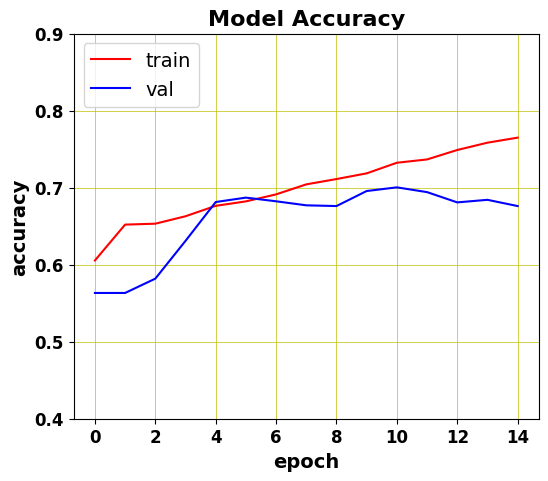

In [27]:
# checks for model accuracy
history = model.fit( X_train, Y_train,
                    epochs = 15, batch_size = 100,
                    callbacks=[save_best], verbose=1,
                    validation_data = (X_val, Y_val))



plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.4, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

In [28]:
model = load_model("/content/model.keras")
score = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  69.39 %


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b77a0509a50>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

Text(0.5, 1.0, 'animal')

<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b77a04c51d0>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

Text(0.5, 1.0, 'animal')

<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b77a03c9010>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

Text(0.5, 1.0, 'plain')

<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b77a03ef490>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

Text(0.5, 1.0, 'plain')

<Figure size 640x480 with 0 Axes>

(<matplotlib.image.AxesImage at 0x7b77a0225850>,
 (np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5)))

Text(0.5, 1.0, 'stripes')

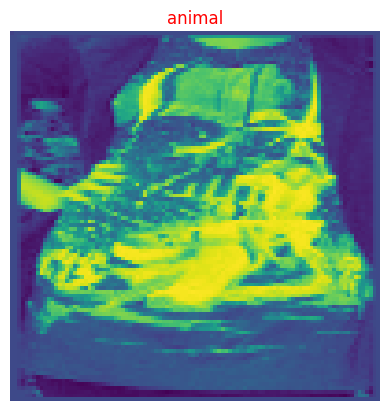

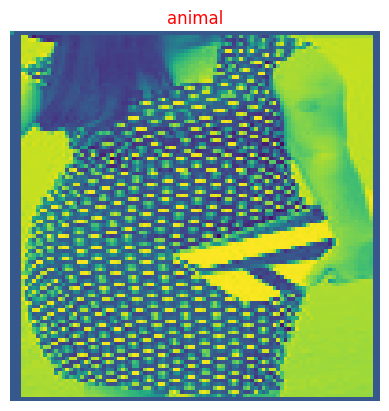

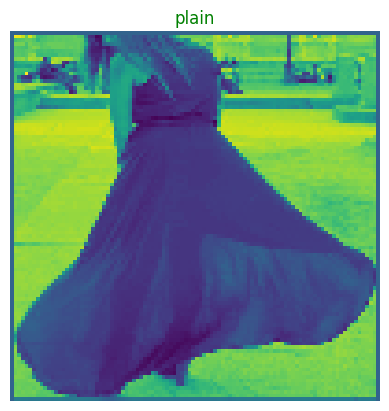

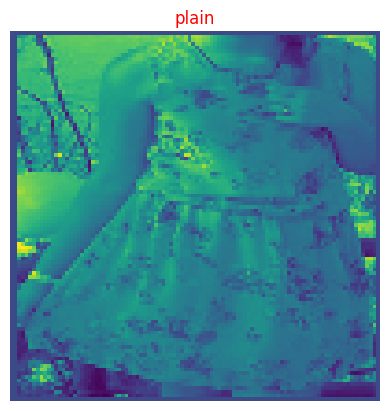

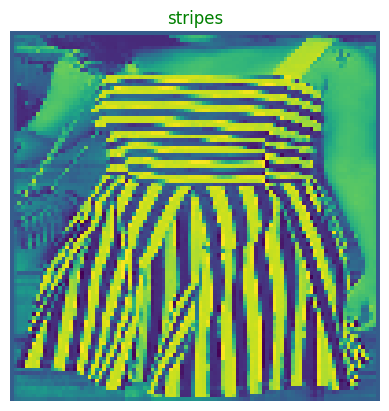

In [29]:
Y_pred = np.round(model.predict(X_test))

np.random.seed(87)
for rand_num in np.random.randint(0, len(Y_test), 5):
  plt.figure()
  plt.imshow(X_test[rand_num].reshape(100, 100)), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

In [30]:
# Test the model using test dataset
def find_similar_images(image_url, no_of_images):


    X_query = image_processing(image_url)
    X_query = X_query/255
    X_query = X_query.reshape(1, 100, 100, 1)
    Y_query = np.round(model.predict(X_query))
    i = np.where(Y_query == 1)[0].sum()
    i = np.where(Y_query == 1)[1][0]
    print('Type detected by model:', encoder.classes_[i].upper())
    df_req = df.loc[ df['category'] == encoder.classes_[i]]
    df_req = df_req.reset_index(drop=True)

    if no_of_images > len(df_req):
        return(print('number of images needed are more than similar images in the dataset'))

    plt.figure()
    show_image_from_url(image_url)
    plt.title('Query Image')

    c = 1
    np.random.seed(13)
    for j in np.random.randint(0, len(df_req), no_of_images):
        plt.figure()
        url = df_req['image_url'].iloc[j]
        show_image_from_url(url)
        plt.title('Similar Image {}'.format(c))
        c += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Type detected by model: PLAIN


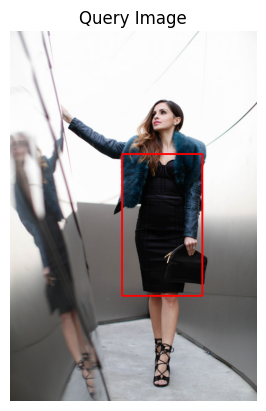

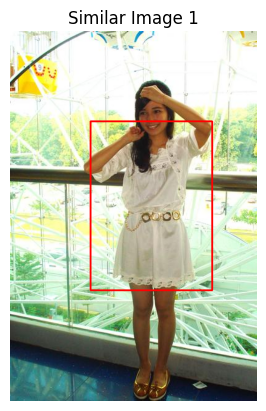

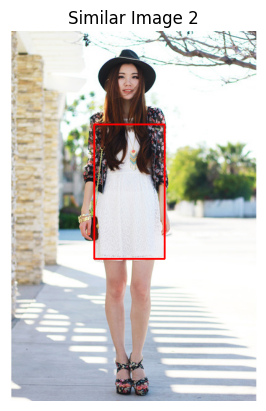

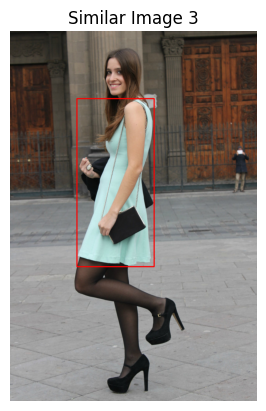

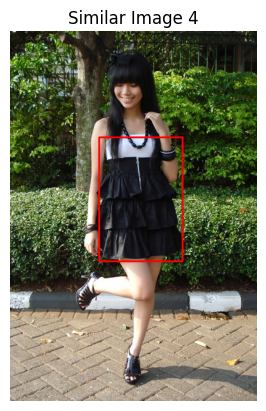

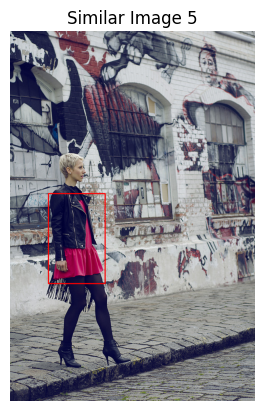

In [33]:
find_similar_images('http://s3-eu-west-1.amazonaws.com/we-attributes/dress/38/c6e22692f9b6430a87958f30b77d3f4a.jpg.png', 5)